## Librairies and customization

In [1]:
import xarray as xr 
import dask 
import numpy as np 
import os 
import time 
import glob
from datetime import date
today=date.today()

import sys
sys.path.insert(0,'/home/albert7a/git/xscale')
import xscale

import xscale.spectral.fft as xfft
from xscale.spectral.tools import plot_spectrum
import xscale.signal.generator as xgen

import matplotlib.pyplot as plt
params = {'figure.figsize' : (15, 8),'legend.fontsize': 16,'xtick.labelsize':16,'ytick.labelsize':16,'axes.labelsize':16,'font.size':16}
plt.rcParams.update(params)


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/xarray/core/merge.py:16: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
%time ds=xr.open_zarr('/store/albert7a/eNATL60/zarr/eNATL60-BLBT02-SSH-1h')
ds

CPU times: user 123 ms, sys: 63.6 ms, total: 187 ms
Wall time: 1.52 s


<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, time_counter: 11688, x: 8354, y: 4729)
Coordinates:
    time_centered         (time_counter) datetime64[ns] dask.array<shape=(11688,), chunksize=(240,)>
  * time_counter          (time_counter) datetime64[ns] 2010-01-19T00:30:00 ... 2009-09-17T23:30:00
Dimensions without coordinates: axis_nbounds, x, y
Data variables:
    nav_lat               (y, x) float32 dask.array<shape=(4729, 8354), chunksize=(240, 480)>
    nav_lon               (y, x) float32 dask.array<shape=(4729, 8354), chunksize=(240, 480)>
    sossheig              (time_counter, y, x) float32 dask.array<shape=(11688, 4729, 8354), chunksize=(240, 240, 480)>
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] dask.array<shape=(11688, 2), chunksize=(240, 2)>
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] dask.array<shape=(11688, 2), chunksize=(240, 2)>
Attributes:
    Conventions:  CF-1.6
    TimeStamp:    24/03/2019 14:43:2

In [3]:
ds_sorted=ds.sortby('time_counter')

In [4]:
print(ds.nbytes/1e9)

1847.304207184


In [5]:
ssh_FMA=ds_sorted.sel(time_counter=slice('2010-02-01','2010-04-30'))['sossheig']

In [6]:
ssh_ASO=ds_sorted.sel(time_counter=slice('2009-08-01','2009-10-31'))['sossheig']

In [7]:
def compute_plot_spectrum_ssh_reg(sizex,sizey):
    ssh_FMA_reg=ssh_FMA[:,2000:2000+sizey,4000:4000+sizex]
    ssh_ASO_reg=ssh_ASO[:,2000:2000+sizey,4000:4000+sizex]
    NPADDING = 2
    SPtime_FMA_reg = xfft.fft(ssh_FMA_reg, dim='time_counter', dx=1., detrend='mean',nfft=ssh_FMA_reg.shape[0]*NPADDING,tapering=True)
    SPtime_ASO_reg = xfft.fft(ssh_ASO_reg, dim='time_counter', dx=1., detrend='mean',nfft=ssh_ASO_reg.shape[0]*NPADDING,tapering=True)
    MEANPSD_FMA=xfft.psd(SPtime_FMA_reg).mean(dim='x').mean(dim='y').load()
    MEANPSD_ASO=xfft.psd(SPtime_ASO_reg).mean(dim='x').mean(dim='y').load()
    freqs_FMA=MEANPSD_FMA.f_time_counter.values
    freqs_FMA = freqs_FMA[NPADDING::] 
    freqs_ASO=MEANPSD_ASO.f_time_counter.values
    freqs_ASO = freqs_ASO[NPADDING::] 

    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.loglog(freqs_FMA,MEANPSD_FMA[NPADDING::],'k',label='winter')
    ax.loglog(freqs_ASO,MEANPSD_ASO[NPADDING::],'r',label='summer')
    ax.set_xlim(1e-3,1)
    ax.grid(which='both',axis='both')
    plt.xlabel('Frequency (cpd)')
    plt.ylabel('PSD (m2/cpd)')
    plt.legend()
    plt.title('Temporal Spectrum of SSH in the box of size '+str(sizex)+' x '+str(sizey))

/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/xarray/core/dataarray.py:218: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif isinstance(data, pd.Panel):


CPU times: user 33.5 s, sys: 1min 59s, total: 2min 32s
Wall time: 10.7 s


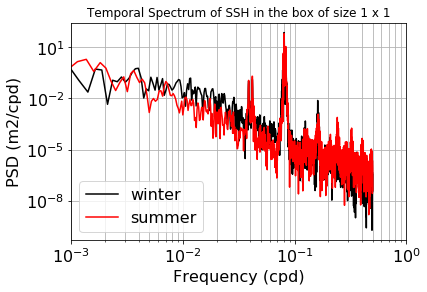

In [8]:
%time compute_plot_spectrum_ssh_reg(1,1) 

CPU times: user 34 s, sys: 1min 58s, total: 2min 32s
Wall time: 11.7 s


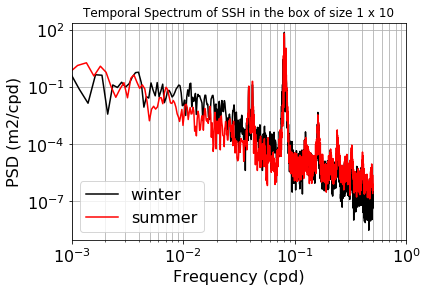

In [9]:
%time compute_plot_spectrum_ssh_reg(1,10) 

CPU times: user 34.1 s, sys: 1min 59s, total: 2min 33s
Wall time: 9.43 s


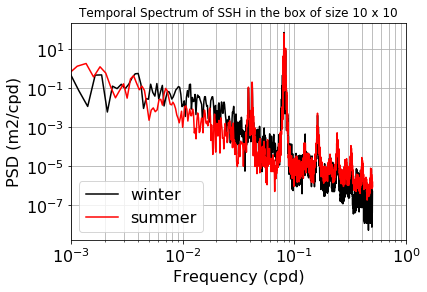

In [11]:
%time compute_plot_spectrum_ssh_reg(10,10) 

CPU times: user 34.3 s, sys: 2min 5s, total: 2min 39s
Wall time: 10.5 s


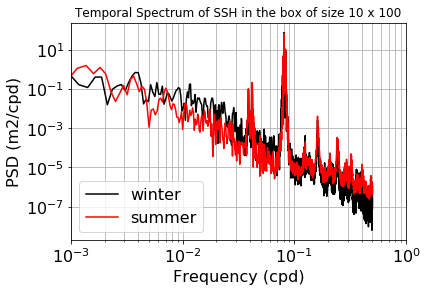

In [12]:
%time compute_plot_spectrum_ssh_reg(10,100) 

CPU times: user 39.3 s, sys: 2min 7s, total: 2min 46s
Wall time: 15.4 s


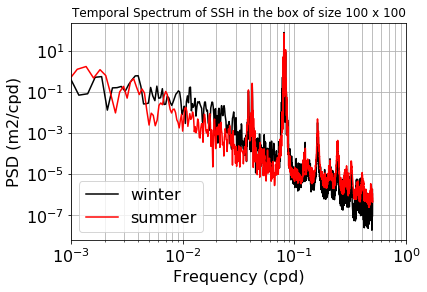

In [13]:
%time compute_plot_spectrum_ssh_reg(100,100) # 100x100 =10 000 times more point

CPU times: user 3min 40s, sys: 10min 47s, total: 14min 28s
Wall time: 1min 59s


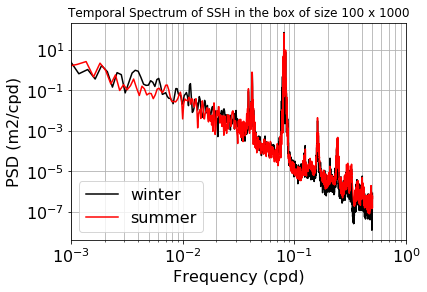

In [14]:
%time compute_plot_spectrum_ssh_reg(100,1000)

In [ ]:
%time compute_plot_spectrum_ssh_reg(1000,1000) # 1000x1000 =1 000 000 times more point

In [8]:
import dask
import dask.threaded
import dask.multiprocessing
from dask.distributed import Client

c = Client()
c

/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/distributed/bokeh/core.py:74: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 13] Permission denied
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:32995 Dashboard: http://127.0.0.1:43974/status,Cluster Workers: 8 Cores: 48 Memory: 134.91 GB


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/xarray/core/dataarray.py:218: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif isinstance(data, pd.Panel):


CPU times: user 3.57 s, sys: 349 ms, total: 3.92 s
Wall time: 8.92 s


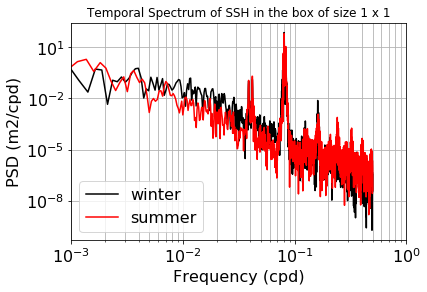

In [9]:
%time compute_plot_spectrum_ssh_reg(1,1) 

CPU times: user 3.18 s, sys: 224 ms, total: 3.4 s
Wall time: 5.21 s


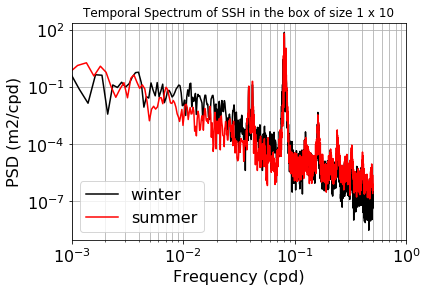

In [10]:
%time compute_plot_spectrum_ssh_reg(1,10) 

CPU times: user 3.23 s, sys: 268 ms, total: 3.49 s
Wall time: 5.56 s


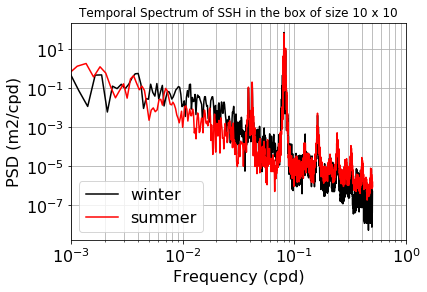

In [11]:
%time compute_plot_spectrum_ssh_reg(10,10) 

CPU times: user 3.43 s, sys: 378 ms, total: 3.81 s
Wall time: 6.34 s


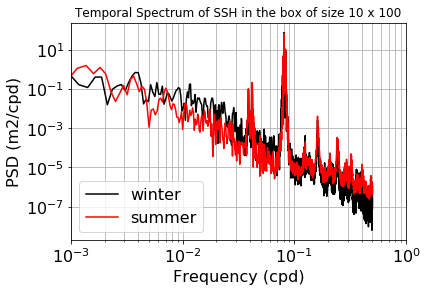

In [12]:
%time compute_plot_spectrum_ssh_reg(10,100) 

CPU times: user 4.93 s, sys: 2.08 s, total: 7.02 s
Wall time: 21.5 s


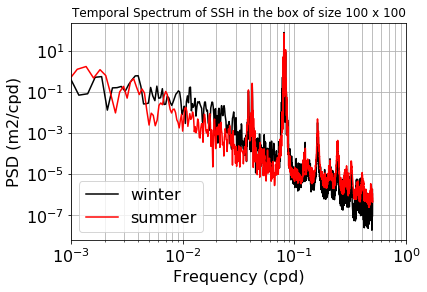

In [13]:
%time compute_plot_spectrum_ssh_reg(100,100) 

CPU times: user 27.8 s, sys: 19.8 s, total: 47.6 s
Wall time: 2min 2s


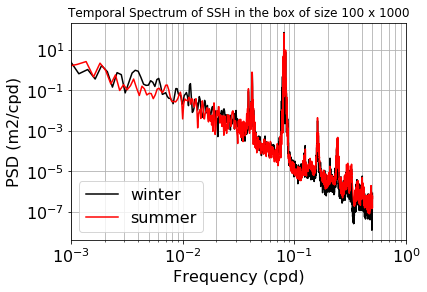

In [14]:
%time compute_plot_spectrum_ssh_reg(100,1000) 

In [ ]:
%time compute_plot_spectrum_ssh_reg(1000,1000) 

distributed.protocol.core - CRITICAL - Failed to Serialize
Traceback (most recent call last):
  File "/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/distributed/protocol/core.py", line 46, in dumps
    for key, value in data.items()
  File "/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/distributed/protocol/core.py", line 47, in <dictcomp>
    if type(value) is Serialize
  File "/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/distributed/protocol/serialize.py", line 164, in serialize
    raise TypeError(msg, str(x)[:10000])
TypeError: ('Could not serialize object of type ImplicitToExplicitIndexingAdapter.', 'ImplicitToExplicitIndexingAdapter(array=NumpyIndexingAdapter(array=array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,\n         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],\n        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,\n         -0.00000000e+00, -0.00000000e+00, -0.000

distributed.batched - ERROR - Error in batched write
Traceback (most recent call last):
  File "/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/distributed/batched.py", line 95, in _background_send
    payload, serializers=self.serializers, on_error="raise"
  File "/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 735, in run
    value = future.result()
  File "/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.throw(*exc_info)  # type: ignore
  File "/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/distributed/comm/tcp.py", line 237, in write
    context={"sender": self._local_addr, "recipient": self._peer_addr},
  File "/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 735, in run
    value = future.result()
  File "/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/s

In [9]:
def compute_plot_spectrum_ssh_reg_dask(sizex,sizey,chunksizex,chunksizey,chunksizet):
    ssh_FMA_reg=ssh_FMA[:,2000:2000+sizey,4000:4000+sizex].chunk({'x':chunksizex,'y':chunksizey,'time_counter':chunksizet})
    ssh_ASO_reg=ssh_ASO[:,2000:2000+sizey,4000:4000+sizex].chunk({'x':chunksizex,'y':chunksizey,'time_counter':chunksizet})
    NPADDING = 2
    SPtime_FMA_reg = xfft.fft(ssh_FMA_reg, dim='time_counter', dx=1., detrend='mean',nfft=ssh_FMA_reg.shape[0]*NPADDING,tapering=True)
    SPtime_ASO_reg = xfft.fft(ssh_ASO_reg, dim='time_counter', dx=1., detrend='mean',nfft=ssh_ASO_reg.shape[0]*NPADDING,tapering=True)
    MEANPSD_FMA=xfft.psd(SPtime_FMA_reg).mean(dim='x').mean(dim='y').load()
    MEANPSD_ASO=xfft.psd(SPtime_ASO_reg).mean(dim='x').mean(dim='y').load()
    freqs_FMA=MEANPSD_FMA.f_time_counter.values
    freqs_FMA = freqs_FMA[NPADDING::] 
    freqs_ASO=MEANPSD_ASO.f_time_counter.values
    freqs_ASO = freqs_ASO[NPADDING::] 

    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.loglog(freqs_FMA,MEANPSD_FMA[NPADDING::],'k',label='winter')
    ax.loglog(freqs_ASO,MEANPSD_ASO[NPADDING::],'r',label='summer')
    ax.set_xlim(1e-3,1)
    ax.grid(which='both',axis='both')
    plt.xlabel('Frequency (cpd)')
    plt.ylabel('PSD (m2/cpd)')
    plt.legend()
    plt.title('Temporal Spectrum of SSH in the box of size '+str(sizex)+' x '+str(sizey))

/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/xarray/core/dataarray.py:218: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif isinstance(data, pd.Panel):


CPU times: user 3.21 s, sys: 2.15 s, total: 5.36 s
Wall time: 17.4 s


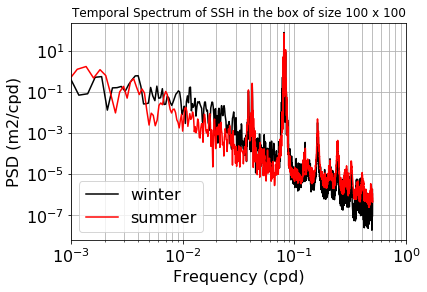

In [10]:
%time compute_plot_spectrum_ssh_reg_dask(100,100,240,240,480) 

CPU times: user 3.09 s, sys: 1.86 s, total: 4.95 s
Wall time: 14.5 s


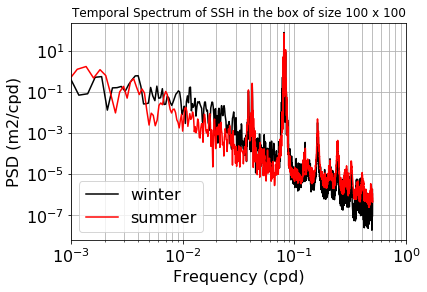

In [11]:
%time compute_plot_spectrum_ssh_reg_dask(100,100,100,100,480) 

CPU times: user 3.43 s, sys: 1.89 s, total: 5.32 s
Wall time: 13.6 s


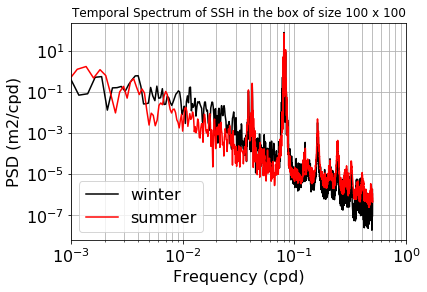

In [12]:
%time compute_plot_spectrum_ssh_reg_dask(100,100,100,100,240) 

CPU times: user 3.82 s, sys: 1.69 s, total: 5.51 s
Wall time: 13.7 s


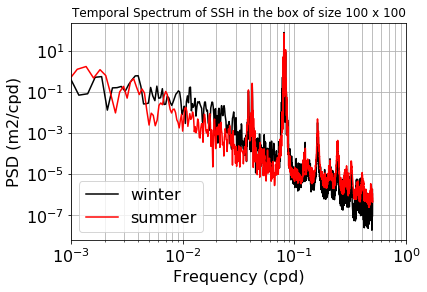

In [16]:
%time compute_plot_spectrum_ssh_reg_dask(100,100,100,100,100) 

CPU times: user 6.66 s, sys: 1.86 s, total: 8.52 s
Wall time: 17.1 s


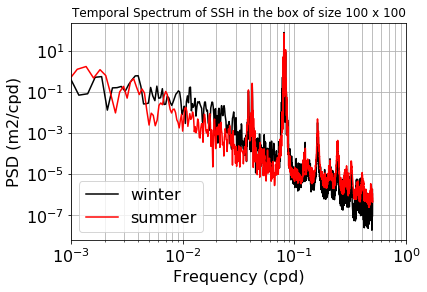

In [15]:
%time compute_plot_spectrum_ssh_reg_dask(100,100,10,10,480) 

CPU times: user 27.1 s, sys: 21 s, total: 48.2 s
Wall time: 1min 56s


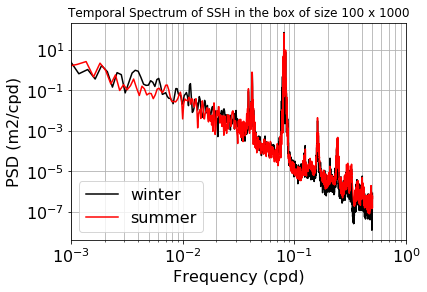

In [17]:
%time compute_plot_spectrum_ssh_reg_dask(100,1000,100,100,100) 

CPU times: user 23.4 s, sys: 20 s, total: 43.4 s
Wall time: 1min 55s


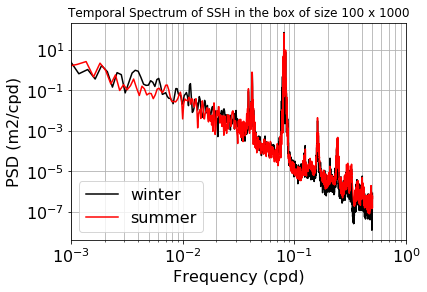

In [18]:
%time compute_plot_spectrum_ssh_reg_dask(100,1000,100,100,240) 

CPU times: user 25.3 s, sys: 25.5 s, total: 50.8 s
Wall time: 2min


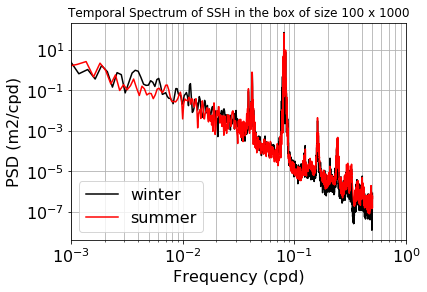

In [19]:
%time compute_plot_spectrum_ssh_reg_dask(100,1000,480,480,480) 

CPU times: user 26.3 s, sys: 27.6 s, total: 53.9 s
Wall time: 2min 15s


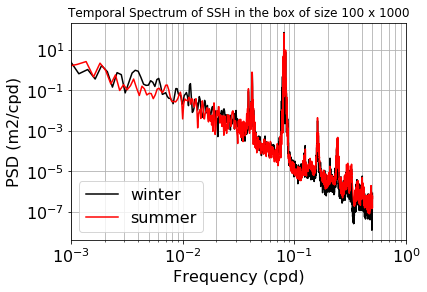

In [20]:
%time compute_plot_spectrum_ssh_reg_dask(100,1000,1000,1000,480) 